# LSTM

In [6]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

In [7]:
x       = pickle.load(open("HargaSaham.dat", "rb"))   #input dataset
xs      = (x-x.min())/(x.max()-x.min())   #Standarized the dataset
N       = xs.shape[0]

#hypreparameter
nc      = 4  
Ts      = 5
x_dim   = 1
alpha   = 0.01
epochs  = 5000

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   

X_train = xt[:-30, 0:x_dim]     
y_train = xt[:-30, x_dim:x_dim+1]  
X_test = xt[-30:, 0:x_dim]     
y_test = xt[-30:, x_dim:x_dim+1]  

In [8]:
x

array([[130.88389311],
       [131.07975813],
       [131.43729465],
       [129.09403274],
       [128.00920016],
       [128.56889645],
       [129.5083658 ],
       [128.52988475],
       [129.03298159],
       [129.43939606],
       [129.76285707],
       [129.26944619],
       [128.4774294 ],
       [127.63506147],
       [126.35555881],
       [126.60127397],
       [126.55707917],
       [128.12471173],
       [129.17582041],
       [129.58218883],
       [129.41354273],
       [126.22383994],
       [127.3439722 ],
       [128.67675041],
       [128.43341164],
       [128.30338093],
       [128.19436356],
       [129.75055   ],
       [129.87932835],
       [127.81237963],
       [126.92688647],
       [125.82230699],
       [126.75517334],
       [128.81501134],
       [127.88007338],
       [126.26708316],
       [126.79415288],
       [125.24305215],
       [125.57266549],
       [124.43613895],
       [124.09764834],
       [124.41861913],
       [123.81631111],
       [125

In [9]:
N

250

In [4]:
xs

array([[0.56291198],
       [0.57333167],
       [0.59235201],
       [0.46769444],
       [0.40998319],
       [0.43975808],
       [0.48973626],
       [0.43768273],
       [0.46444663],
       [0.48606719],
       [0.50327477],
       [0.47702614],
       [0.43489219],
       [0.39007965],
       [0.32201227],
       [0.3350839 ],
       [0.33273281],
       [0.41612821],
       [0.47204541],
       [0.49366352],
       [0.48469183],
       [0.31500505],
       [0.37459419],
       [0.44549573],
       [0.43255052],
       [0.42563311],
       [0.41983357],
       [0.50262005],
       [0.50947084],
       [0.39951267],
       [0.35240594],
       [0.29364418],
       [0.34327109],
       [0.45285098],
       [0.40311386],
       [0.31730552],
       [0.34534473],
       [0.2628288 ],
       [0.28036368],
       [0.21990239],
       [0.20189526],
       [0.21897036],
       [0.1869286 ],
       [0.26910553],
       [0.30352665],
       [0.3350848 ],
       [0.35838696],
       [0.430

In [5]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.05689490303867713
------------- 2 -------------
0.06128216375410757
------------- 3 -------------
0.06133170750482643
------------- 4 -------------
0.06132400511465377
------------- 5 -------------
0.061315548578705574
------------- 6 -------------
0.06130708343507773
------------- 7 -------------
0.0612986195018388
------------- 8 -------------
0.061290156887347604
------------- 9 -------------
0.061281695571850155
------------- 10 -------------
0.06127323553393173
------------- 11 -------------
0.06126477675218492
------------- 12 -------------
0.06125631920523185
------------- 13 -------------
0.06124786287172185
------------- 14 -------------
0.06123940773033163
------------- 15 -------------
0.06123095375976474
------------- 16 -------------
0.0612225009387493
------------- 17 -------------
0.0612140492460377
------------- 18 -------------
0.06120559866040667
------------- 19 -------------
0.061197149160654545
------------- 20 -------------
0.061188

0.06000649147922861
------------- 161 -------------
0.05999797725011586
------------- 162 -------------
0.0599894609029853
------------- 163 -------------
0.05998094241168665
------------- 164 -------------
0.059972421749985176
------------- 165 -------------
0.05996389889156193
------------- 166 -------------
0.05995537381001251
------------- 167 -------------
0.05994684647884721
------------- 168 -------------
0.059938316871489636
------------- 169 -------------
0.05992978496127595
------------- 170 -------------
0.05992125072145556
------------- 171 -------------
0.05991271412518927
------------- 172 -------------
0.059904175145549035
------------- 173 -------------
0.059895633755517735
------------- 174 -------------
0.059887089927988274
------------- 175 -------------
0.0598785436357627
------------- 176 -------------
0.059869994851552304
------------- 177 -------------
0.05986144354797627
------------- 178 -------------
0.05985288969756203
------------- 179 -------------
0.059844

0.05854141917483453
------------- 327 -------------
0.05853211512519371
------------- 328 -------------
0.05852280305041904
------------- 329 -------------
0.058513482903009756
------------- 330 -------------
0.058504154635295666
------------- 331 -------------
0.058494818199438026
------------- 332 -------------
0.05848547354742737
------------- 333 -------------
0.05847612063108446
------------- 334 -------------
0.05846675940205911
------------- 335 -------------
0.05845738981183088
------------- 336 -------------
0.058448011811707
------------- 337 -------------
0.058438625352823195
------------- 338 -------------
0.05842923038614286
------------- 339 -------------
0.0584198268624564
------------- 340 -------------
0.0584104147323816
------------- 341 -------------
0.05840099394636265
------------- 342 -------------
0.05839156445466928
------------- 343 -------------
0.058382126207397494
------------- 344 -------------
0.05837267915446828
------------- 345 -------------
0.058363223

0.05692541611380413
------------- 486 -------------
0.056914119017864764
------------- 487 -------------
0.056902803995912986
------------- 488 -------------
0.05689147096974297
------------- 489 -------------
0.05688011986094603
------------- 490 -------------
0.056868750590910636
------------- 491 -------------
0.05685736308082205
------------- 492 -------------
0.05684595725166396
------------- 493 -------------
0.05683453302421755
------------- 494 -------------
0.05682309031906122
------------- 495 -------------
0.05681162905657208
------------- 496 -------------
0.05680014915692542
------------- 497 -------------
0.056788650540094944
------------- 498 -------------
0.056777133125853
------------- 499 -------------
0.056765596833771303
------------- 500 -------------
0.05675404158321983
------------- 501 -------------
0.056742467293368896
------------- 502 -------------
0.05673087388318804
------------- 503 -------------
0.05671926127144694
------------- 504 -------------
0.056707

0.054817178222191884
------------- 647 -------------
0.054801861748430145
------------- 648 -------------
0.054786512530216054
------------- 649 -------------
0.05477113046634648
------------- 650 -------------
0.05475571545560426
------------- 651 -------------
0.05474026739675998
------------- 652 -------------
0.054724786188575326
------------- 653 -------------
0.054709271729806004
------------- 654 -------------
0.05469372391920409
------------- 655 -------------
0.05467814265552086
------------- 656 -------------
0.05466252783751004
------------- 657 -------------
0.054646879363929875
------------- 658 -------------
0.05463119713354697
------------- 659 -------------
0.05461548104513838
------------- 660 -------------
0.054599730997494864
------------- 661 -------------
0.054583946889423716
------------- 662 -------------
0.05456812861975163
------------- 663 -------------
0.054552276087328495
------------- 664 -------------
0.05453638919102918
------------- 665 -------------
0.0

0.05186287367461003
------------- 808 -------------
0.051841067449538106
------------- 809 -------------
0.051819214569294766
------------- 810 -------------
0.05179731498352174
------------- 811 -------------
0.05177536864262141
------------- 812 -------------
0.05175337549776428
------------- 813 -------------
0.05173133550089411
------------- 814 -------------
0.05170924860473571
------------- 815 -------------
0.05168711476280091
------------- 816 -------------
0.051664933929394724
------------- 817 -------------
0.05164270605962298
------------- 818 -------------
0.051620431109397326
------------- 819 -------------
0.051598109035443436
------------- 820 -------------
0.05157573979530634
------------- 821 -------------
0.05155332334735729
------------- 822 -------------
0.05153085965080071
------------- 823 -------------
0.05150834866568013
------------- 824 -------------
0.051485790352885134
------------- 825 -------------
0.05146318467415776
------------- 826 -------------
0.0514

0.04774262911787062
------------- 969 -------------
0.04771334862387264
------------- 970 -------------
0.04768402721407185
------------- 971 -------------
0.04765466503029445
------------- 972 -------------
0.04762526221577744
------------- 973 -------------
0.047596056818062935
------------- 974 -------------
0.0475669001535071
------------- 975 -------------
0.04753770395573486
------------- 976 -------------
0.04750846837233429
------------- 977 -------------
0.04747919355227369
------------- 978 -------------
0.047449879645899085
------------- 979 -------------
0.04742052680493183
------------- 980 -------------
0.04739113518246613
------------- 981 -------------
0.04736170493296687
------------- 982 -------------
0.047332236212266655
------------- 983 -------------
0.04730272917756327
------------- 984 -------------
0.04727318398741645
------------- 985 -------------
0.04724360080174552
------------- 986 -------------
0.047213979781826475
------------- 987 -------------
0.0471843

0.04301114260875027
------------- 1124 -------------
0.04297939851545008
------------- 1125 -------------
0.04294764960768337
------------- 1126 -------------
0.04291589615371553
------------- 1127 -------------
0.04288413842188385
------------- 1128 -------------
0.042852376680585884
------------- 1129 -------------
0.04282061119826669
------------- 1130 -------------
0.04278884224340898
------------- 1131 -------------
0.04275707008452004
------------- 1132 -------------
0.042725294990120496
------------- 1133 -------------
0.04269351722873283
------------- 1134 -------------
0.042661737068869617
------------- 1135 -------------
0.042629954779022254
------------- 1136 -------------
0.04259817062764928
------------- 1137 -------------
0.0425663848831643
------------- 1138 -------------
0.04253459781392543
------------- 1139 -------------
0.04250280968822296
------------- 1140 -------------
0.04247102077426858
------------- 1141 -------------
0.04243923134018351
------------- 1142 ----

0.03832887439606236
------------- 1280 -------------
0.03830260450316077
------------- 1281 -------------
0.03827636268102534
------------- 1282 -------------
0.0382501490799108
------------- 1283 -------------
0.038223963849094565
------------- 1284 -------------
0.03819780713687524
------------- 1285 -------------
0.038171679090570676
------------- 1286 -------------
0.038145579856517876
------------- 1287 -------------
0.03811950958007047
------------- 1288 -------------
0.038093468405598
------------- 1289 -------------
0.0380674564764841
------------- 1290 -------------
0.03804147393512683
------------- 1291 -------------
0.03801552092293588
------------- 1292 -------------
0.037989597580332685
------------- 1293 -------------
0.03796370404674929
------------- 1294 -------------
0.037937840460627176
------------- 1295 -------------
0.037912006959416586
------------- 1296 -------------
0.03788620367957614
------------- 1297 -------------
0.037860430756571556
------------- 1298 ----

0.034557683044742465
------------- 1440 -------------
0.03453716674629076
------------- 1441 -------------
0.03451669051192811
------------- 1442 -------------
0.03449625434952908
------------- 1443 -------------
0.034475858266305726
------------- 1444 -------------
0.0344555022688105
------------- 1445 -------------
0.034435186362941156
------------- 1446 -------------
0.03441491055394308
------------- 1447 -------------
0.03439467484641388
------------- 1448 -------------
0.03437447924430672
------------- 1449 -------------
0.03435432375093431
------------- 1450 -------------
0.03433420836897222
------------- 1451 -------------
0.03431413310046295
------------- 1452 -------------
0.03429409794681898
------------- 1453 -------------
0.03427410290882731
------------- 1454 -------------
0.0342541479866526
------------- 1455 -------------
0.03423423317984097
------------- 1456 -------------
0.034214358487323085
------------- 1457 -------------
0.03419452390742013
------------- 1458 -----

0.031761143860291115
------------- 1601 -------------
0.03174682323025904
------------- 1602 -------------
0.03173253779448067
------------- 1603 -------------
0.03171828749791227
------------- 1604 -------------
0.03170407228535333
------------- 1605 -------------
0.031689892101445724
------------- 1606 -------------
0.031675746890678494
------------- 1607 -------------
0.031661636597389416
------------- 1608 -------------
0.031647561165765954
------------- 1609 -------------
0.03163352053984932
------------- 1610 -------------
0.03161951466353476
------------- 1611 -------------
0.03160554348057559
------------- 1612 -------------
0.03159160693458409
------------- 1613 -------------
0.03157770496903283
------------- 1614 -------------
0.03156383752725926
------------- 1615 -------------
0.03155000455246573
------------- 1616 -------------
0.03153620598772187
------------- 1617 -------------
0.03152244177596752
------------- 1618 -------------
0.03150871186001365
------------- 1619 --

0.029957056271848734
------------- 1756 -------------
0.0299482076405879
------------- 1757 -------------
0.029939382960644606
------------- 1758 -------------
0.029930582176315442
------------- 1759 -------------
0.029921805231945257
------------- 1760 -------------
0.02991305207192907
------------- 1761 -------------
0.02990432264071122
------------- 1762 -------------
0.029895616882787607
------------- 1763 -------------
0.029886934742704825
------------- 1764 -------------
0.029878276165061966
------------- 1765 -------------
0.029869641094510343
------------- 1766 -------------
0.029861029475753913
------------- 1767 -------------
0.029852441253551288
------------- 1768 -------------
0.029843876372714483
------------- 1769 -------------
0.029835334778110734
------------- 1770 -------------
0.02982681641466265
------------- 1771 -------------
0.029818321227348888
------------- 1772 -------------
0.029809849161204355
------------- 1773 -------------
0.029801400161320858
------------

KeyboardInterrupt: 

/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_20230/1945362580.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,0],label = 'pred')
/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_20230/1945362580.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,1],label = 'real')


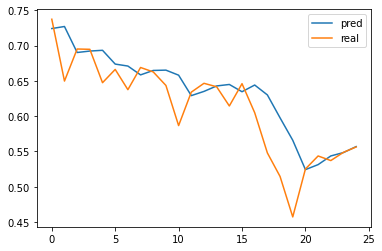

In [4]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

plt.plot(np.array(out)[:,0],label = 'pred')
plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()